# Import Library

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.config.list_physical_devices('GPU'))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4, MobileNetV2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


#### Set Seed 

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

#### Config 

In [3]:
IMAGE_PATH = f'./Crawling/Data/'

batch_size = 16

classes = 19

learning_rate = 5e-5
wd = 0.0005
max_lr = 2e-3
min_lr = 5e-5
cycle_len = 20

EPOCHS = 100

# Load Data 

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
)

val_datagen = ImageDataGenerator(
    rescale=1./255.,
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    IMAGE_PATH+f'train/',
    target_size=[256,256],
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    IMAGE_PATH+f'val/',
    target_size=[256,256],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5700 images belonging to 19 classes.
Found 475 images belonging to 19 classes.


# Build Model 

In [6]:
with tf.device('/device:GPU:0'):
    base_model = MobileNetV2(
        include_top=False,
        input_shape=(256,256,3)
    )
    # base_model = EfficientNetB4(
    #     include_top=False,
    #     input_shape=(256,256,3)
    # )
base_model.trainable = False

In [7]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(classes, activation='softmax')

In [8]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer,
])

#### Compile Model 

In [9]:
optimizer = tfa.optimizers.AdamW(learning_rate, wd)

model.compile(
    optimizer = optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [10]:
checkpoint_filepath = './checkpoints/best_model.h5'
mon = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False,
                                                monitor='val_accuracy', mode='max', save_best_only=True,
                                        verbose=1)

def trianfle_fn(x):
    return 1. / (2.**(x - 1))
clr_f = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate = max_lr,
    maximal_learning_rate = min_lr,
    step_size = cycle_len,
    scale_fn = trianfle_fn
)

clr = tf.keras.callbacks.LearningRateScheduler(clr_f)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, 
                                          verbose=2, mode='auto', baseline=None, 
                                          restore_best_weights=True)

callbacks = [mon, clr, es]

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 19)                24339     
Total params: 2,282,323
Trainable params: 24,339
Non-trainable params: 2,257,984
_________________________________________________________________


# Training 

In [12]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
)

Epoch 1/100
357/357 [==============================] - ETA: 0s - loss: 1.3898 - accuracy: 0.5856
Epoch 00001: val_accuracy improved from -inf to 0.80000, saving model to ./checkpoints/best_model.h5
357/357 [==============================] - 10s 28ms/step - loss: 1.3898 - accuracy: 0.5856 - val_loss: 0.6761 - val_accuracy: 0.8000
Epoch 2/100
356/357 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.7906
Epoch 00002: val_accuracy improved from 0.80000 to 0.81895, saving model to ./checkpoints/best_model.h5
357/357 [==============================] - 9s 26ms/step - loss: 0.6876 - accuracy: 0.7912 - val_loss: 0.6169 - val_accuracy: 0.8189
Epoch 3/100
357/357 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8625
Epoch 00003: val_accuracy did not improve from 0.81895
357/357 [==============================] - 9s 25ms/step - loss: 0.4829 - accuracy: 0.8625 - val_loss: 0.6508 - val_accuracy: 0.8126
Epoch 4/100
356/357 [============================>.]

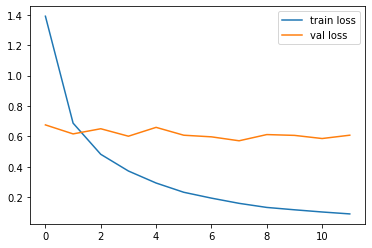

In [22]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

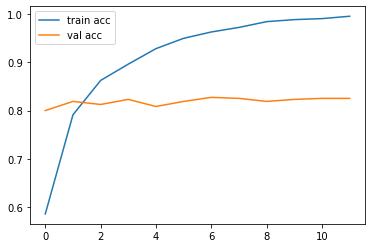

In [21]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

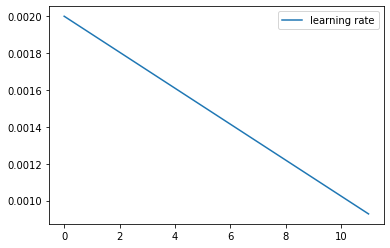

In [23]:
plt.plot(history.history['lr'], label='learning rate')
plt.legend()
plt.show()

In [24]:
import tensorflowjs as tfjs

In [25]:
tfjs_target_dir = f'./checkpoints/best_model_js.json'

In [26]:
tfjs.converters.save_keras_model(model, tfjs_target_dir)

/home/sungjin/anaconda3/envs/React-AI/lib/python3.7/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [12]:
r = next(iter(train_generator))

In [13]:
img, label = r[0][0], r[1][0]

In [20]:
model(r[0])

<tf.Tensor: shape=(16, 17), dtype=float32, numpy=
array([[ 2.9310672 , -0.7518295 ,  0.18807179, -1.1059742 ,  1.4337091 ,
         0.62084526,  0.5712175 , -1.9444466 ,  0.17567024, -0.7015872 ,
         0.7865558 , -1.9372294 ,  1.1910641 ,  3.3170536 , -0.94791603,
        -0.63262546, -1.0124608 ],
       [ 3.0522242 , -0.53401685,  0.01308825, -0.5120572 ,  1.5207728 ,
         1.2865975 ,  0.75698715, -1.8376343 , -0.61159384, -1.5248569 ,
         0.52810353, -0.4565504 ,  0.64924103,  3.1790032 , -1.5489216 ,
         1.0847452 , -0.9211453 ],
       [ 1.6581061 ,  0.25070667, -0.74965554, -2.283928  ,  1.0408789 ,
         0.30336374,  0.5115896 , -2.4495153 , -0.18667272, -0.8930874 ,
         2.2171867 , -0.60989845,  0.25996208,  0.8169579 , -0.42487338,
        -0.26345688, -1.1385922 ],
       [ 2.0454292 ,  0.74517614, -1.0220816 , -0.5404272 ,  0.48623416,
         0.7361423 , -0.24974157, -2.5934794 ,  0.6020428 , -1.1695511 ,
         1.3634168 ,  0.68955433,  0.17838